# Model Building

In [1]:
## Google colab path setup
%cd /content/drive//My\ Drive/Notebook/ML_Chal_BankingSubs/

/content/drive/My Drive/Notebook/ML_Chal_BankingSubs


In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor 
%matplotlib inline

In [2]:
# from rav_utils import preprocess_data,data_sampling,response_encoder,result_show
from sklearn import metrics 
import lightgbm as lgb 
import catboost as cb

In [2]:
from sklearn.utils import resample
import json

def up_sample(X,y):
    """It takes the X and y data frames,
    In output it provides upsampled data frames"""
    
    # concatenate our training data back together
    X4 = pd.concat([X,y], axis=1)
    
    # separate minority and majority classes
    # not_fraud = X[X.Class==0]
    # fraud = X[X.Class==1]
    no = X4[X4.y==0]
    yes = X4[X4.y==1]
    # print('yes ,no:' ,yes.count(), no.count())
    a1=no.count()[0]
    a2=yes.count()[0]
    if a1>=a2:
        # upsample minority
        upsampled = resample(yes,
                                  replace=True, # sample with replacement
                                  n_samples=len(no), # match number in majority class
                                  random_state=27) # reproducible results
        upsampled = pd.concat([no, upsampled])
    else:
        # upsample minority
        upsampled = resample(no,
                                  replace=True, # sample with replacement
                                  n_samples=len(yes), # match number in majority class
                                  random_state=27) # reproducible results
    # combine majority and upsampled minority
        upsampled = pd.concat([yes, upsampled])
    
    # check new class counts
    # upsampled.y.value_counts()
    upsampled = upsampled.reset_index().drop("index",axis=1)
    return upsampled
def categorical_column(data):
    """It takes the data frame and return the list of categorical column"""
        # Categorical boolean mask
    categorical_feature_mask = data.dtypes==object
    
    # filter categorical columns by using mask and turn it into a list
    categorical_cols = data.columns[categorical_feature_mask].tolist()
    return categorical_cols

def numerical_column(data):
    """It takes the data frame and return the list of numerical column
    Note:-here it takes only dtypes == int64 and float64,
    which can be modified as per requirement"""
    # filter categorical columns by using mask and turn it into a list
    num_cols1 = data.columns[data.dtypes == 'int64'].tolist()
    num_cols2 = data.columns[data.dtypes == 'float64'].tolist()
    num_cols1.extend(num_cols2)
    return num_cols1
def all_score(true,predictions):
    """It takes the true value and predicted values 
    In output it provides graph"""
    
    f1score=metrics.f1_score(true,predictions)
    precision=metrics.precision_score(true,predictions)
    recall=metrics.recall_score(true,predictions)
    auc=metrics.roc_auc_score(true,predictions)
    pl2=[f1score,precision,recall,auc]
    xx=['f1score','precision','recall','auc']
    
    ax=sns.barplot(xx,pl2)
    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.004))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.set_ylim(0,1)
    plt.show()

def feature_dict(alpha, feature, train_df, train_df_y):
    # value_count: it contains a dict like
    print('X feature :-',feature)
    value_count = train_df[feature].value_counts()
    
    # feat_dict : Categorical feature Dict, which contains the probability array for each categorical variable
    feat_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of the particular 
        # categorical feature belongs to particular class
        # vec is 2 diamensional vector
        vec = []
        for k in range(0, 2):
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df_y==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 20*alpha))

        # we are adding the categorical feature to the dict as key and vec as value
        feat_dict[i]=vec
    return feat_dict

# Get Response coded feature
def response_feature(alpha, feature, train_df, train_df_y):

    feat_dict = feature_dict(alpha, feature, train_df, train_df_y)
    # value_count is similar in get_fea_dict
    value_count = train_df[feature].value_counts()
    
    # res_fea: response coded feature, it will contain the response coded feature for each feature value in the data
    res_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to res_fea
    # if not we will add [1/2, 1/2] to res_fea
    for index, row in train_df.iterrows():
        if row[feature] in dict(value_count).keys():
            res_fea.append(feat_dict[row[feature]])
        else:
            res_fea.append([1/2, 1/2])
    return res_fea

def ResponseEncoder(categorical_cols, x_df, y_df):

    """
    This function takes Categorical column names and X and Y dataframe.

    Returns the response coded dataframe
    """
    print("Encoding dataset")
    print("Shape of the dataset before encoding: ", x_df.shape)
    for i in (categorical_cols):
        temp_response_coded_feature = np.array(response_feature(alpha=1, feature=i, train_df=x_df, train_df_y=y_df))
        df_response = pd.DataFrame(temp_response_coded_feature, columns=[i+"_0", i+"_1"])
        x_df = pd.concat([x_df, df_response], axis=1)

    # Remove the categorical features as the response coded features are added
    x_df = x_df.drop(categorical_cols, axis=1)
    return x_df
def test_data_encode(path,X):
    aa=pd.read_json(path)
    n_col=numerical_column(X)
    n_X=X[n_col]
    for i,j in enumerate(aa):
    #     print(j)
        col0=X[j].replace(aa[j][0])
        col1=X[j].replace(aa[j][1])
        col0,col1=pd.DataFrame(col0),pd.DataFrame(col1)
        col=pd.concat([col0,col1],axis=1)
        col.columns=[(str(j)+'_0'),(str(j)+'_1')]
        n_X=pd.concat([n_X,col],axis=1)
    return n_X

In [4]:
data_path="C:\\Datasets\\MLData\\Banking_subscription\\bank-additional-full.csv"
data=pd.read_csv(data_path,sep=';')
np.shape(data)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
data2=data.drop(['duration','day_of_week'], axis=1)
# data2=data.drop(['nr.employed','euribor3m','duration','day_of_week'], axis=1)
np.shape(data2) ####### Droped out data

(41188, 19)

In [6]:
####### Without dropping duplicate column ################
X=data2.drop('y',axis=1)
cat_cols2=categorical_column(X)
data_cat2=X[cat_cols2]

y=data2['y']
print("shape of x and y",X.shape,y.shape)
y.replace({"no":0, "yes":1}, inplace=True)

shape of x and y (41188, 18) (41188,)


In [8]:
X_Encod=ResponseEncoder(cat_cols2, X, y)
print("Shape of the dataset after encoding: ", X_Encod.shape)

Encoding dataset
Shape of the dataset before encoding:  (41188, 18)
X feature :- job
X feature :- marital
X feature :- education
X feature :- default
X feature :- housing
X feature :- loan
X feature :- contact
X feature :- month
X feature :- poutcome
Shape of the dataset after encoding:  (41188, 27)


In [11]:
X_Encod.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_0,job_1,marital_0,marital_1,education_0,education_1,default_0,default_1,housing_0,housing_1,loan_0,loan_1,contact_0,contact_1,month_0,month_1,poutcome_0,poutcome_1
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.892593,0.107407,0.898108,0.101892,0.895615,0.104385,0.870983,0.129017,0.890784,0.109216,0.886370,0.113630,0.947092,0.052908,0.935021,0.064979,0.911446,0.088554
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.916520,0.083480,0.898108,0.101892,0.890823,0.109177,0.947429,0.052571,0.890784,0.109216,0.886370,0.113630,0.947092,0.052908,0.935021,0.064979,0.911446,0.088554
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.916520,0.083480,0.898108,0.101892,0.890823,0.109177,0.870983,0.129017,0.883451,0.116549,0.886370,0.113630,0.947092,0.052908,0.935021,0.064979,0.911446,0.088554
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.869565,0.130435,0.898108,0.101892,0.914360,0.085640,0.870983,0.129017,0.890784,0.109216,0.886370,0.113630,0.947092,0.052908,0.935021,0.064979,0.911446,0.088554
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.916520,0.083480,0.898108,0.101892,0.890823,0.109177,0.870983,0.129017,0.890784,0.109216,0.889438,0.110562,0.947092,0.052908,0.935021,0.064979,0.911446,0.088554


In [109]:
####### At testing Phase ###########
path="tst_encode.json"
X_Encod=test_data_encode(path,X)
X_Encod.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_0,...,default_0,default_1,housing_0,housing_1,loan_0,loan_1,contact_0,contact_1,month_0,month_1
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.892593,...,0.870983,0.129017,0.890784,0.109216,0.886370,0.113630,0.947092,0.052908,0.935021,0.064979
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.916520,...,0.947429,0.052571,0.890784,0.109216,0.886370,0.113630,0.947092,0.052908,0.935021,0.064979
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.916520,...,0.870983,0.129017,0.883451,0.116549,0.886370,0.113630,0.947092,0.052908,0.935021,0.064979
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.869565,...,0.870983,0.129017,0.890784,0.109216,0.886370,0.113630,0.947092,0.052908,0.935021,0.064979
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0.916520,...,0.870983,0.129017,0.890784,0.109216,0.889438,0.110562,0.947092,0.052908,0.935021,0.064979


In [29]:
######## No improvement in result part while appliying Standard Scaler ############
# from sklearn.preprocessing import StandardScaler
# from sklearn.externals.joblib import dump, load
# sc=StandardScaler()
# X_scl=sc.fit_transform(X_Encod)
# dump(sc, 'std_scaler.bin', compress=True)
### For Testing Dataset #############
# new=load('std_scaler.bin')
# new.fit_transform(X_Encod)

## Model Training Initiated

In [65]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pickle
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [66]:
## Data split
train_x, test_x, train_y, test_y = train_test_split(X_Encod, y, test_size=0.2,random_state=42)

#### XGBClassifier

In [67]:
# fit model no training data
model = XGBClassifier(objective='binary:logistic')
model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.9044309559939302


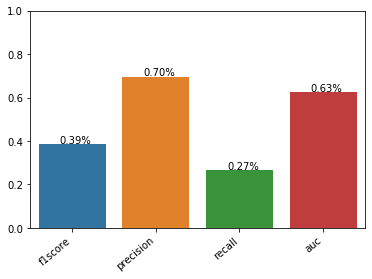

array([[28814,   431],
       [ 2718,   987]], dtype=int64)

In [68]:
# cheking training accuracy
y_pred = model.predict(train_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(train_y,predictions)
print('accuracy:',accuracy)
all_score(train_y,predictions)### Train
confusion=metrics.confusion_matrix(train_y,predictions)
confusion

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.8969410050983249


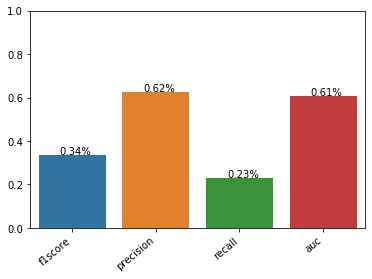

array([[7174,  129],
       [ 720,  215]], dtype=int64)

In [69]:
# cheking initial test accuracy
y_pred = model.predict(test_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(test_y,predictions)
print('accuracy:',accuracy)
all_score(test_y,predictions)### Test
confusion=metrics.confusion_matrix(test_y,predictions)
confusion

## Data Upsampling

In [70]:
upsampled=up_sample(X_Encod,y)

In [71]:
X_final=upsampled.drop('y',axis=1)
y_final=upsampled['y']

#### XGBClassifier

In [72]:
train_x, test_x, train_y, test_y = train_test_split(X_final, y_final, test_size=0.25,random_state=42)
# fit model no training data
model = XGBClassifier(objective='binary:logistic')
model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.7538032176863303


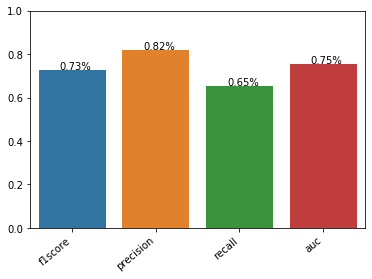

array([[23394,  3963],
       [ 9534, 17931]], dtype=int64)

In [73]:
# cheking training accuracy
y_pred = model.predict(train_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(train_y,predictions)
print('accuracy:',accuracy)
all_score(train_y,predictions)### Train
confusion=metrics.confusion_matrix(train_y,predictions)
confusion

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.7511218124110759


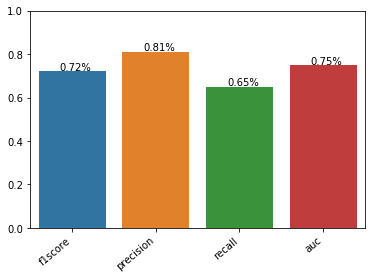

array([[7819, 1372],
       [3176, 5907]], dtype=int64)

In [74]:
y_pred = model.predict(test_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(test_y,predictions)
print('accuracy:',accuracy)
all_score(test_y,predictions)### Test
confusion=metrics.confusion_matrix(test_y,predictions)
confusion

**LGB**

In [75]:
############### LGBOOST Algorithm###############
small_lgb_model = lgb.LGBMClassifier()
small_lgb_model.fit(train_x, train_y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.777954106015833


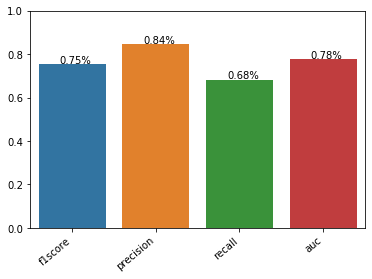

array([[23914,  3443],
       [ 8730, 18735]], dtype=int64)

In [76]:
# cheking training accuracy
y_pred=small_lgb_model.predict(train_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(train_y,predictions)
print('accuracy:',accuracy)
all_score(train_y,predictions)### Train
confusion=metrics.confusion_matrix(train_y,predictions)
confusion
#0.7804348619167487

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.7692349786582029


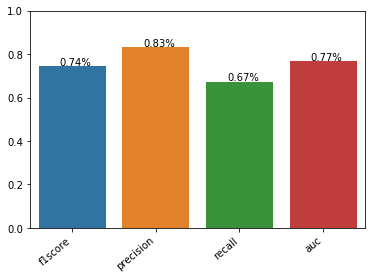

array([[7941, 1250],
       [2967, 6116]], dtype=int64)

In [77]:
y_pred = small_lgb_model.predict(test_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(test_y,predictions)
print('accuracy:',accuracy)
all_score(test_y,predictions)### Test
confusion=metrics.confusion_matrix(test_y,predictions)
confusion
#0.7723541643865601

**Catboost**

In [84]:
cb_model = cb.CatBoostClassifier(iterations=2000,
                            learning_rate=0.1,
                            depth=8,
                            eval_metric='Accuracy',
                            random_seed = 0,
                            bagging_temperature = 0.2,
                            od_type='Iter',
                            metric_period = 75,
                            od_wait=100)
cb_model.fit(train_x, train_y)

0:	learn: 0.7414906	total: 51.9ms	remaining: 1m 43s
75:	learn: 0.7703294	total: 3.51s	remaining: 1m 28s
150:	learn: 0.8011930	total: 6.9s	remaining: 1m 24s
225:	learn: 0.8252526	total: 10.2s	remaining: 1m 20s
300:	learn: 0.8439678	total: 13.5s	remaining: 1m 16s
375:	learn: 0.8663128	total: 17s	remaining: 1m 13s
450:	learn: 0.8807231	total: 20.4s	remaining: 1m 10s
525:	learn: 0.8930356	total: 23.9s	remaining: 1m 6s
600:	learn: 0.9028492	total: 27.3s	remaining: 1m 3s
675:	learn: 0.9117872	total: 30.6s	remaining: 60s
750:	learn: 0.9193025	total: 34.2s	remaining: 56.9s
825:	learn: 0.9260516	total: 37.8s	remaining: 53.7s
900:	learn: 0.9332385	total: 41.1s	remaining: 50.2s
975:	learn: 0.9390573	total: 44.6s	remaining: 46.7s
1050:	learn: 0.9444748	total: 48s	remaining: 43.4s
1125:	learn: 0.9491080	total: 51.3s	remaining: 39.8s
1200:	learn: 0.9541060	total: 54.7s	remaining: 36.4s
1275:	learn: 0.9579366	total: 58.1s	remaining: 33s
1350:	learn: 0.9604721	total: 1m 1s	remaining: 29.5s
1425:	learn

accuracy: 0.9784210718324761


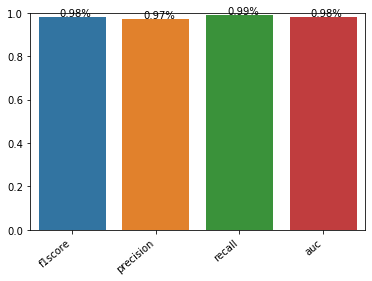

array([[26497,   860],
       [  323, 27142]], dtype=int64)

In [85]:
# cheking training accuracy
y_pred=cb_model.predict(train_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(train_y,predictions)
print('accuracy:',accuracy)
all_score(train_y,predictions)### Train
confusion=metrics.confusion_matrix(train_y,predictions)
confusion

accuracy: 0.9338951515814818


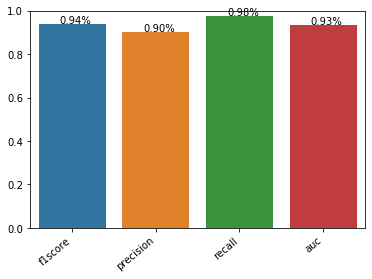

array([[8201,  990],
       [ 218, 8865]], dtype=int64)

In [86]:
y_pred = cb_model.predict(test_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(test_y,predictions)
print('accuracy:',accuracy)
all_score(test_y,predictions)### Test
confusion=metrics.confusion_matrix(test_y,predictions)
confusion

**Stacking**

In [87]:
!pip install vecstack

You should consider upgrading via the 'c:\programdata\anaconda3\python.exe -m pip install --upgrade pip' command.


In [88]:
from sklearn import svm
from vecstack import stacking
from sklearn.metrics import roc_auc_score

In [89]:
########## Stacking With SVC ###########
models = [cb.CatBoostClassifier(iterations=700,
                            learning_rate=0.1,
                            depth=8,
                            eval_metric='Accuracy',
                            random_seed = 0,
                            bagging_temperature = 0.2,
                            od_type='Iter',
                            metric_period = 75,
                            od_wait=100),####FULL:[0.95873731]###
    lgb.LGBMClassifier(n_estimators=260, num_leaves=28, max_depth=6),##FULL:[0.95787809]###
#     xgb.XGBRegressor(random_state=0, n_jobs=-1, learning_rate=0.1, 
#                       n_estimators=100, max_depth=3),
]
S_train, S_test = stacking(models,train_x,train_y,test_x,
                                 regression=False,
                                 mode='oof_pred_bag',needs_proba=False,
                                 save_dir=None,metric=roc_auc_score, 
                                 n_folds=4, stratified=False,
                                 shuffle=True,
                                 random_state=0,
                                 verbose=2)

stacking_final = svm.SVC()
stacking_final.fit(S_train, train_y)

task:         [classification]
n_classes:    [2]
metric:       [roc_auc_score]
mode:         [oof_pred_bag]
n_models:     [2]

model  0:     [CatBoostClassifier]
0:	learn: 0.7380582	total: 61ms	remaining: 42.7s
75:	learn: 0.7725703	total: 3.05s	remaining: 25s
150:	learn: 0.8034585	total: 5.86s	remaining: 21.3s
225:	learn: 0.8284123	total: 8.58s	remaining: 18s
300:	learn: 0.8457535	total: 11.5s	remaining: 15.3s
375:	learn: 0.8630460	total: 14.4s	remaining: 12.4s
450:	learn: 0.8815303	total: 17.6s	remaining: 9.73s
525:	learn: 0.8959043	total: 20.8s	remaining: 6.88s
600:	learn: 0.9044654	total: 23.9s	remaining: 3.94s
675:	learn: 0.9155317	total: 26.9s	remaining: 954ms
699:	learn: 0.9184989	total: 27.9s	remaining: 0us
    fold  0:  [0.87130200]
0:	learn: 0.7365989	total: 41.3ms	remaining: 28.9s
75:	learn: 0.7733243	total: 3.05s	remaining: 25s
150:	learn: 0.8064987	total: 6.26s	remaining: 22.8s
225:	learn: 0.8297986	total: 9.64s	remaining: 20.2s
300:	learn: 0.8489396	total: 13s	remaining: 1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


    fold  0:  [0.78590544]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


    fold  1:  [0.78817490]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


    fold  2:  [0.78789593]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


    fold  3:  [0.78332927]
    ----
    MEAN:     [0.78632638] + [0.00193910]
    FULL:     [0.78632017]



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

accuracy: 0.8726606107037321


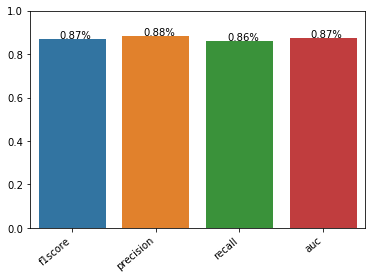

array([[8155, 1036],
       [1291, 7792]], dtype=int64)

In [90]:
# cheking testing accuracy
y_pred=stacking_final.predict(S_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(test_y,predictions)
print('accuracy:',accuracy)
all_score(test_y,predictions)### Test
confusion=metrics.confusion_matrix(test_y,predictions)
confusion

In [91]:
# let's divide our dataset into training set and hold out set by 50%
X_train, X_test, y_train, y_test= train_test_split(X_final, y_final,test_size=0.3, random_state= 42)

In [92]:
# let's split the training set again into training and test dataset 
X_train_11, X_test_11, y_train_11, y_test_11=train_test_split(X_train, y_train,test_size=0.2, random_state= 42)

In [93]:
catboost=cb.CatBoostClassifier(iterations=2000,
                            learning_rate=0.1,
                            depth=8,
                            eval_metric='Accuracy',
                            random_seed = 0,
                            bagging_temperature = 0.2,
                            od_type='Iter',
                            metric_period = 75,
                            od_wait=100)####FULL:[0.95873731]###
catboost.fit(X_train_11,y_train_11)
catboost.score(X_test_11, y_test_11)

0:	learn: 0.7355190	total: 43.4ms	remaining: 1m 26s
75:	learn: 0.7729949	total: 3.02s	remaining: 1m 16s
150:	learn: 0.8054626	total: 5.99s	remaining: 1m 13s
225:	learn: 0.8281582	total: 9.12s	remaining: 1m 11s
300:	learn: 0.8480688	total: 12.5s	remaining: 1m 10s
375:	learn: 0.8636064	total: 15.6s	remaining: 1m 7s
450:	learn: 0.8794127	total: 19.4s	remaining: 1m 6s
525:	learn: 0.8945838	total: 22.3s	remaining: 1m 2s
600:	learn: 0.9035008	total: 25.6s	remaining: 59.6s
675:	learn: 0.9128820	total: 28.6s	remaining: 56s
750:	learn: 0.9217257	total: 31.6s	remaining: 52.5s
825:	learn: 0.9272714	total: 34.8s	remaining: 49.4s
900:	learn: 0.9327193	total: 38.3s	remaining: 46.7s
975:	learn: 0.9392910	total: 41.3s	remaining: 43.3s
1050:	learn: 0.9451298	total: 44.2s	remaining: 39.9s
1125:	learn: 0.9499182	total: 47s	remaining: 36.4s
1200:	learn: 0.9543889	total: 50.5s	remaining: 33.6s
1275:	learn: 0.9595436	total: 53.7s	remaining: 30.5s
1350:	learn: 0.9635013	total: 56.7s	remaining: 27.2s
1425:	le

0.9298417041235099

In [94]:
lgbm=lgb.LGBMClassifier(n_estimators=260, num_leaves=28, max_depth=6)
lgbm.fit(X_train_11,y_train_11)
lgbm.score(X_test_11, y_test_11)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7852257181942545

In [95]:
train1=catboost.predict(X_test)
train2=lgbm.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [96]:
meta_inpt=np.column_stack((train1,train2))

In [97]:
RFC_meta_model=svm.SVC(random_state=6)
RFC_meta_model.fit(meta_inpt,y_test)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=6, shrinking=True,
  tol=0.001, verbose=False)

In [98]:
def stack_result(X_test_11,y_test_11):
  """ Provide X and y data for testing"""
  t1=catboost.predict(X_test_11)
  t2=lgbm.predict(X_test_11)
  tt=np.column_stack((t1,t2))
  y_pred=RFC_meta_model.predict(tt)
  predictions = [round(value) for value in y_pred]
  accuracy = accuracy_score(y_test_11,predictions)
  print('accuracy:',accuracy)
  all_score(y_test_11,predictions)### Test
  confusion=metrics.confusion_matrix(y_test_11,predictions)
  print('confusion:',confusion)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.9298417041235099


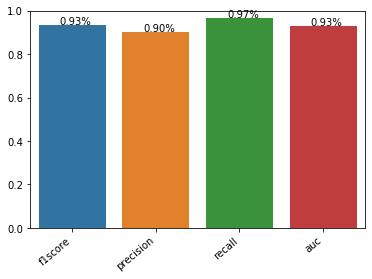

confusion: [[4568  542]
 [ 176 4948]]


In [99]:
stack_result(X_test_11,y_test_11)

**HYPER Parameter Tuning**

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
param_grid={
   
    ' learning_rate':[1,0.5,0.1,0.01,0.001],
    'max_depth': [3,5,10,20],
    'n_estimators':[10,50,100,200]
    
}

In [0]:
grid= GridSearchCV(XGBClassifier(objective='binary:logistic'),param_grid,n_jobs =-1, verbose=3)

In [108]:
grid.fit(train_x,train_y)
# To  find the parameters givingmaximum accuracy
grid.best_params_

In [0]:
# Create new model using the same parameters
new_model=XGBClassifier(learning_rate= 1, max_depth= 5, n_estimators= 50)
new_model.fit(train_x, train_y)

In [0]:
# cheking training accuracy
y_pred = new_model.predict(train_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(train_y,predictions)
print('accuracy:',accuracy)
all_score(train_y,predictions)### Train
confusion=metrics.confusion_matrix(train_y,predictions)
confusion

In [0]:
y_pred = new_model.predict(test_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(test_y,predictions)
print('accuracy:',accuracy)
all_score(test_y,predictions)### Test
confusion=metrics.confusion_matrix(test_y,predictions)
confusion

## CLUSTRING #####

In [111]:
!pip install kneed

You should consider upgrading via the 'c:\programdata\anaconda3\python.exe -m pip install --upgrade pip' command.


In [112]:
from sklearn.cluster import KMeans
from kneed import KneeLocator
# from file_operations import file_methods

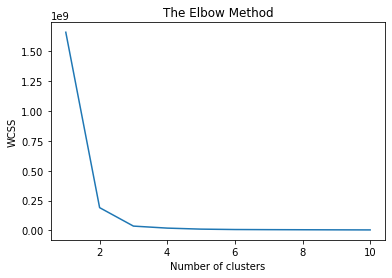

In [120]:
wcss=[]
for i in range (1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42) # initializing the KMeans object
    kmeans.fit(X_Encod) # fitting the data to the KMeans Algorithm
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss) # creating the graph between WCSS and the number of clusters
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
fig1 = plt.gcf()
plt.show()
# plt.draw()
fig1.savefig('K-Means_Elbow.PNG',dpi=100) # saving the elbow plot locally
# finding the value of the optimum cluster programmatically
kn = KneeLocator(range(1, 11), wcss, curve='convex', direction='decreasing')

In [124]:
#### Optimal number of cluster #########
kn.knee

2

In [137]:
kmeans=KMeans(n_clusters=3,init='k-means++',random_state=42) # initializing the KMeans object
y_kmeans=kmeans.fit_predict(X_Encod)

In [138]:
yy=pd.DataFrame(y_kmeans)
yy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 1 columns):
0    41188 non-null int32
dtypes: int32(1)
memory usage: 161.0 KB


In [142]:
"""T-distributed Stochastic Neighbor Embedding (t-SNE) is a machine learning algorithm for visualization developed by Laurens van der Maaten and Geoffrey Hinton. ... It is often used to visualize high-level representations learned by an artificial neural network."""

'T-distributed Stochastic Neighbor Embedding (t-SNE) is a machine learning algorithm for visualization developed by Laurens van der Maaten and Geoffrey Hinton. ... It is often used to visualize high-level representations learned by an artificial neural network.'

In [1]:
# %matplotlib inline
# from sklearn.manifold import TSNE
# # T-SNE plot for dataset
# model = TSNE(n_components=2, random_state=0, perplexity=30)
# tsne_data = model.fit_transform(X_Encod) 
# plt.figure(figsize=(8,8))
# plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=y.values)
# plt.show()